In [2]:
import pandas as pd

iris = pd.read_csv('iris.tmls')

df = pd.DataFrame(iris)

# Remove useless row which inform on the type of features
df = df.drop(df.index[0])

# Convert object type to float
df["sepal length"] = pd.to_numeric(df["sepal length"])
df["sepal width"] = pd.to_numeric(df["sepal width"])
df["petal length"] = pd.to_numeric(df["petal length"])
df["petal width"] = pd.to_numeric(df["petal width"])

df["class"]

KeyError: 0

COMPUTE GAUSSIAN DISTRIB

In [432]:
from math import exp
from math import sqrt
from math import pi
from random import randrange

def compute_mean(dataset: pd.DataFrame, target: str):
  return dataset.groupby(by=[target]).mean()

def compute_std(dataset: pd.DataFrame, target: str):
  return dataset.groupby(by=[target]).std()

def compute_norm_prob(val: float, mean: float, std: float):
  numerator = exp(((val - mean) / std)**2 * (-1 / 2))
  denominator = std * sqrt(2 * pi)
  return numerator / denominator

GAUSSIAN NAIVES BAYES LOGIC

In [433]:
from math import log
from math import exp

def get_classifier(dataset: pd.DataFrame, target: str):
  return dataset[target].unique()

def naive_bayes_learner(train: pd.DataFrame, test: pd.DataFrame, target: str):
  classifier = get_classifier(pd.concat([test, train]), target)
  predictions = []
  probs = []
  # We will use Log probabilities instead of multiply probabilities because we don't want to deal with too small values
  prior_first = log(len(test[test[target] == classifier[0]]) / len(test))
  prior_second = log(len(test[test[target] == classifier[1]]) / len(test))
  test_copy = test.drop(target, axis=1)
  mean_df = compute_mean(train, target)
  std_df = compute_std(train, target)
  for idx in test_copy.index:
    first_res = 0
    second_res = 0
    for col in test_copy.columns:
      first_res += log(compute_norm_prob(test_copy[col][idx], mean_df[col][classifier[0]], std_df[col][classifier[0]]))
      second_res += log(compute_norm_prob(test_copy[col][idx], mean_df[col][classifier[1]], std_df[col][classifier[1]]))
    # Choose the biggest probability to predict
    if (first_res + prior_first >= second_res + prior_second):
      predictions.append(classifier[0])
    else:
      predictions.append(classifier[1])
    # Keep probabilities for positive class
    if (classifier[0] == 1):
      probs.append(exp(first_res + prior_first))
    else:
      probs.append(exp(second_res + prior_second))
  return predictions, probs

In [434]:
def compute_roc_score(test, probs):
  tpr = []
  fpr = []
  thresholds = probs
  thresholds.sort()
  test_length = len(test)
  for threshold in thresholds:
    tp = 0
    fp = 0
    for idx in range(test_length):
      if (probs[idx] >= threshold and test[idx] == 1):
        tp += 1
      if (probs[idx] >= threshold and test[idx] == 0):
        fp += 1
    fpr.append(fp / (len(test) - sum(test)))
    tpr.append(tp / sum(test))
  return fpr, tpr



In [435]:
# Split randomly dataset in K folds
def split_dataset(dataset: pd.DataFrame, k_folds: int):
  fold_size = int(len(dataset.index) / k_folds)
  folds = []
  for _ in range(k_folds):
    fold = []
    for _ in range(fold_size):
      idx = randrange(len(dataset.index))
      fold.append(dataset.iloc[idx])
      dataset = dataset.drop(dataset.index[idx])
    folds.append(pd.DataFrame(fold))
  return folds

def get_accuracy(results: list, predictions: list):
  accuracy = 0
  for i in range(len(predictions)):
    if (predictions[i] == results[i]):
      accuracy += 1
  accuracy = accuracy / len(predictions)
  return accuracy

def cross_validation(dataset: pd.DataFrame, k_folds: int, target: str):
  dataset_copy = dataset.copy()
  # Convert categorical to numerical for target
  dataset_copy[target] = pd.Categorical(dataset_copy[target])
  dataset_copy[target] = dataset_copy[target].cat.codes
  folds = split_dataset(dataset_copy, k_folds)
  accuracy_array = []
  test_array = []
  probs_array = []
  # Iterate naive bayes learner for each folds : 1 fold for testing and the other ones for training
  for idx in range(k_folds):
    results = folds[idx][target].to_list()
    predictions, probs = naive_bayes_learner(train=pd.concat(folds[:idx] + folds[idx + 1 :]), test=folds[idx], target=target)
    accuracy = get_accuracy(results, predictions)
    test_array.append(folds[idx][target].to_list())
    probs_array.append(probs)
    accuracy_array.append(accuracy)
  print(accuracy_array)
  test_array = [item for sublist in test_array for item in sublist]
  probs_array = [item for sublist in probs_array for item in sublist]
  return accuracy_array, test_array, probs_array

Without Iris-Setosa

[0.9, 1.0, 0.9, 1.0, 0.9, 0.9, 1.0, 0.8, 1.0, 0.9]


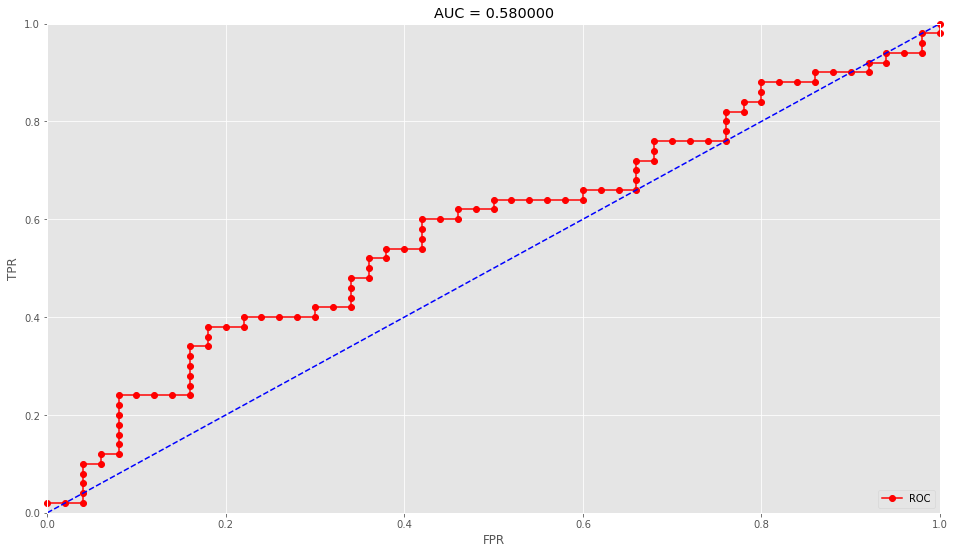

In [436]:
from matplotlib import pyplot as plt
from numpy import trapz

accuracy_array, test_array, probs_array = cross_validation(df[df["class"] != "Iris-setosa"], 10, "class")

fpr, tpr = compute_roc_score(test_array, probs_array)

plt.plot(fpr, tpr, marker="o", linestyle="solid", color="red", label="ROC", clip_on=False)
plt.plot([0, 1], [0, 1], linestyle="dashed", color="blue")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('AUC = %f'%(-1 * trapz(tpr, fpr)))
plt.show()

Without Iris-versicolor

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


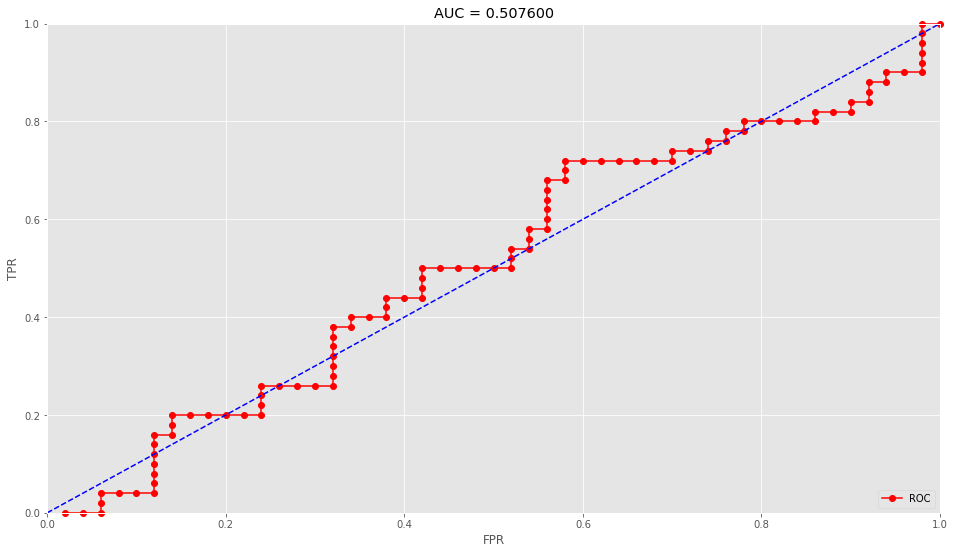

In [437]:
accuracy_array, test_array, probs_array = cross_validation(df[df["class"] != "Iris-versicolor"], 10, "class")

fpr, tpr = compute_roc_score(test_array, probs_array)

plt.plot(fpr, tpr, marker="o", linestyle="solid", color="red", label="ROC", clip_on=False)
plt.plot([0, 1], [0, 1], linestyle="dashed", color="blue")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('AUC = %f'%(-1 * trapz(tpr, fpr)))
plt.show()

Without Iris-virginica

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


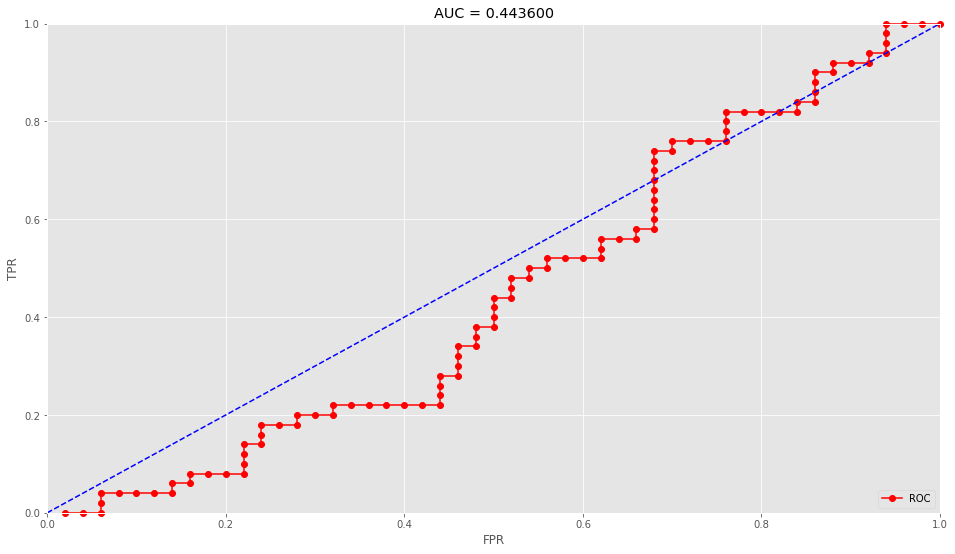

In [438]:
accuracy_array, test_array, probs_array = cross_validation(df[df["class"] != "Iris-virginica"], 10, "class")

fpr, tpr = compute_roc_score(test_array, probs_array)

plt.plot(fpr, tpr, marker="o", linestyle="solid", color="red", label="ROC", clip_on=False)
plt.plot([0, 1], [0, 1], linestyle="dashed", color="blue")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('AUC = %f'%(-1 * trapz(tpr, fpr)))
plt.show()